## Poetry Generation using LSTM 

In this notebook, I will try to generate a poem by American poet Robert Frost. The poem I am using is 'The Road Not Taken' and can be downloaded from the link given below. 

Poetry generation belongs to a class of NLP called language modelling. The idea itself is not so different from a seq2seq model, the difference here is that we won't be having an encoder network but just a decoder network. For language modelling tasks such as poetry generation, the network architecture is similar to the decoder network in a seq2seq model.


https://www.poetryfoundation.org/poems/44272/the-road-not-taken


### Basic Imports 

In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


### Setting Random Seed and Reproducible results in Keras

In [3]:
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)

rn.seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)(Makes training very slow)

tf.set_random_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

### Constants 

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 256
EPOCHS = 1000
HIDDEN_DIM = 25

### Loading Pre-Trained Glove Vectors 

We will be using 50 dim Glove vecors here 

In [5]:
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.50d.txt'),encoding='utf8') as f:
  
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found {} word vectors'.format(len(word2vec)))

Found 400000 word vectors


### Printing the original Poem

In [6]:
with open('Robert_Frost.txt') as poem:
    for line in poem:
        print(line)

Two roads diverged in a yellow wood,

And sorry I could not travel both

And be one traveler, long I stood

And looked down one as far as I could

To where it bent in the undergrowth; 



Then took the other, as just as fair,

And having perhaps the better claim

Because it was grassy and wanted wear,

Though as for that the passing there

Had worn them really about the same,



And both that morning equally lay

In leaves no step had trodden black.

Oh, I kept the first for another day! 

Yet knowing how way leads on to way

I doubted if I should ever come back.



I shall be telling this with a sigh

Somewhere ages and ages hence:

Two roads diverged in a wood, and I,

I took the one less traveled by,

And that has made all the difference.



Whose woods these are I think I know.

His house is in the village, though; 

He will not see me stopping here

To watch his woods fill up with snow.



My little horse must think it queer

To stop without a farmhouse near

Between the woods and

### Creating  Inputs and Targets from the Poem

We are using a method similar to teacher forcing in seq2seq decoder. Here the target is shifted by a seqence length of 1.

In [7]:
input_texts = []
target_texts = []


for line in open('Robert_Frost.txt'):
    
    line = line.rstrip()
    
    if not line:
        continue
            
    input_line = '<sos> ' + line  # <sos> is start of sentence tocken 
    target_line = line + ' <eos>' # <eos> is end of sentence tocken 
    
    input_texts.append(input_line)
    target_texts.append(target_line)

In [8]:
all_lines = input_texts + target_texts 

In [9]:
# Checking if everythig is loaded correctly

if len(all_lines) == 0:
    print('Empty')

### Tokenizing 

In [10]:
# We are using '' as filter so that it doesn't filter out our sos and eos tockens which contain special characters

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters= '') 

In [11]:
tokenizer.fit_on_texts(all_lines)

In [12]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

### Max seq length in the data 

In [13]:
max_sequence_length_in_data = max(len(seq) for seq in input_sequences)

In [14]:
print('Max Seq lenght in data:', max_sequence_length_in_data)

Max Seq lenght in data: 12


### Word -> integer mapping

In [15]:
word2idx = tokenizer.word_index

In [16]:
print(len(word2idx))

3056


In [17]:
assert('<sos>' in word2idx) # checking id <sos> is in word2idx 

In [18]:
assert('<eos>' in word2idx) # checking id <eos> is in word2idx 

### Padding 

In [19]:
max_sequence_length = min(MAX_SEQUENCE_LENGTH,max_sequence_length_in_data)

In [20]:
input_sequences = pad_sequences(input_sequences,maxlen=max_sequence_length,padding='post')
target_sequences = pad_sequences(target_sequences,maxlen=max_sequence_length,padding='post')

In [21]:
print('shape of input tensor:',input_sequences.shape)

shape of input tensor: (1436, 12)


In [22]:
print('shape of target tensor:',target_sequences.shape)

shape of target tensor: (1436, 12)


### Creating embedding matrix

In [23]:
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)

In [24]:
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

In [25]:
for word,i in word2idx.items():
    
    if i < MAX_VOCAB_SIZE:
        
        embedding_vector = word2vec.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector 
            

In [26]:
# Notice the shape of embedding matrix is (MAX_VOCAB_SIZE,EMBEDDING_DIM ), we are using 50 dim Glove vectors here instead of 100

print('Embedding Matrix Shape:',embedding_matrix.shape)

Embedding Matrix Shape: (3000, 50)


### One-hot encoding the targets

We have to do it this way because in the previous toxic comment or mnist classification our targets were not seqences. Each input did not yield a softmax output, therfore we were able to use sparse categorical cross entropy loss. Here, each input gives us an output, this creates problem with sparse categorical cross entropy loss. Therefore, inorder to use just the categorical cross entropy loss we must one hot the targets. 

In [27]:
one_hot_targets = np.zeros((len(input_sequences),max_sequence_length,num_words))

In [28]:
for i, target_sequences in enumerate (target_sequences):
    
    for t,word in enumerate(target_sequences):
        
        if word > 0:
            
            one_hot_targets[i,t,word] = 1

In [29]:
print('Shape of one_hot_targets:',one_hot_targets.shape)

Shape of one_hot_targets: (1436, 12, 3000)


### Building the Model

#### Load pre-trained word embeddings into an Embedding layer

In [30]:
# We let the model update the weights of the pre-trained embeddings 

embedding_layer = Embedding(input_dim = num_words,output_dim= EMBEDDING_DIM, weights=[embedding_matrix])
  

#### Layers 

In [31]:
input_ = Input(shape=(max_sequence_length,))

# we do not want the model to initialize the hidden and cell states. 
# Since we want to use the same value for the generative session as well.    

initial_h = Input(shape=(HIDDEN_DIM,))
initial_c = Input(shape=(HIDDEN_DIM,))

x = embedding_layer(input_)

lstm = LSTM(HIDDEN_DIM,return_sequences=True,return_state=True)

# don't need the states here, we only need to them when we generate poetry later 

x,_,_ = lstm(x, initial_state=[initial_h, initial_c]) 

dense = Dense(num_words,activation='softmax')

output = dense(x)

#### Model 

In [32]:
model = Model(inputs= [input_,initial_h,initial_c],outputs= output)

In [33]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics= ['accuracy'])

# note that accuracy doesn't really mean much here 

In [34]:
# Initialiting the hidden and cell states 

z = np.zeros((len(input_sequences),HIDDEN_DIM))

In [35]:
train = model.fit(x= [input_sequences,z,z],y= one_hot_targets,batch_size= BATCH_SIZE,
                  epochs= EPOCHS,validation_split= VALIDATION_SPLIT)

Train on 1148 samples, validate on 288 samples
Epoch 1/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 5.6116 - acc: 0.0048 - val_loss: 5.6753 - val_acc: 0.0052
Epoch 2/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 5.5936 - acc: 0.0088 - val_loss: 5.6591 - val_acc: 0.0119
Epoch 3/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 5.5711 - acc: 0.0271 - val_loss: 5.6374 - val_acc: 0.0457
Epoch 4/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 5.5416 - acc: 0.0597 - val_loss: 5.6081 - val_acc: 0.0709
Epoch 5/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 5.5020 - acc: 0.0789 - val_loss: 5.5701 - val_acc: 0.0781
Epoch 6/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 5.4516 - acc: 0.0857 - val_loss: 5.5228 - val_acc: 0.0802
Epoch 7/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 5.3901 - acc: 0.0853 - val_loss: 5.4670 - val_acc: 0.0796
E

1148/1148 [==============================] - 5s 4ms/step - loss: 4.1382 - acc: 0.0833 - val_loss: 4.7097 - val_acc: 0.0833
Epoch 61/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1332 - acc: 0.0833 - val_loss: 4.7094 - val_acc: 0.0833
Epoch 62/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1285 - acc: 0.0833 - val_loss: 4.7096 - val_acc: 0.0833
Epoch 63/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1238 - acc: 0.0833 - val_loss: 4.7090 - val_acc: 0.0833
Epoch 64/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1191 - acc: 0.0833 - val_loss: 4.7090 - val_acc: 0.0833
Epoch 65/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1144 - acc: 0.0833 - val_loss: 4.7088 - val_acc: 0.0833
Epoch 66/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 4.1096 - acc: 0.0833 - val_loss: 4.7091 - val_acc: 0.0833
Epoch 67/1000
1148/1148 [==============================

Epoch 120/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8485 - acc: 0.0869 - val_loss: 4.6662 - val_acc: 0.0848
Epoch 121/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8450 - acc: 0.0871 - val_loss: 4.6674 - val_acc: 0.0854
Epoch 122/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8413 - acc: 0.0874 - val_loss: 4.6672 - val_acc: 0.0851
Epoch 123/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8377 - acc: 0.0873 - val_loss: 4.6664 - val_acc: 0.0848
Epoch 124/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8340 - acc: 0.0875 - val_loss: 4.6673 - val_acc: 0.0851
Epoch 125/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8304 - acc: 0.0877 - val_loss: 4.6664 - val_acc: 0.0851
Epoch 126/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.8267 - acc: 0.0880 - val_loss: 4.6663 - val_acc: 0.0854
Epoch 127/1000
1148/1148 [========

1148/1148 [==============================] - 5s 5ms/step - loss: 3.6291 - acc: 0.1123 - val_loss: 4.6830 - val_acc: 0.0961
Epoch 180/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6252 - acc: 0.1127 - val_loss: 4.6838 - val_acc: 0.0964
Epoch 181/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6215 - acc: 0.1126 - val_loss: 4.6859 - val_acc: 0.0964
Epoch 182/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6176 - acc: 0.1129 - val_loss: 4.6843 - val_acc: 0.0964
Epoch 183/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6138 - acc: 0.1132 - val_loss: 4.6844 - val_acc: 0.0964
Epoch 184/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6100 - acc: 0.1132 - val_loss: 4.6858 - val_acc: 0.0966
Epoch 185/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.6060 - acc: 0.1135 - val_loss: 4.6864 - val_acc: 0.0966
Epoch 186/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 3.3950 - acc: 0.1273 - val_loss: 4.7067 - val_acc: 0.0975
Epoch 239/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3909 - acc: 0.1275 - val_loss: 4.7066 - val_acc: 0.0969
Epoch 240/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3868 - acc: 0.1278 - val_loss: 4.7076 - val_acc: 0.0969
Epoch 241/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3827 - acc: 0.1280 - val_loss: 4.7078 - val_acc: 0.0969
Epoch 242/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3787 - acc: 0.1281 - val_loss: 4.7074 - val_acc: 0.0972
Epoch 243/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3746 - acc: 0.1286 - val_loss: 4.7085 - val_acc: 0.0972
Epoch 244/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.3705 - acc: 0.1286 - val_loss: 4.7073 - val_acc: 0.0972
Epoch 245/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 3.1531 - acc: 0.1482 - val_loss: 4.7405 - val_acc: 0.0984
Epoch 298/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1492 - acc: 0.1483 - val_loss: 4.7421 - val_acc: 0.0990
Epoch 299/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1452 - acc: 0.1484 - val_loss: 4.7420 - val_acc: 0.0981
Epoch 300/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1413 - acc: 0.1492 - val_loss: 4.7441 - val_acc: 0.0981
Epoch 301/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1373 - acc: 0.1496 - val_loss: 4.7445 - val_acc: 0.0978
Epoch 302/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1334 - acc: 0.1498 - val_loss: 4.7446 - val_acc: 0.0987
Epoch 303/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 3.1295 - acc: 0.1506 - val_loss: 4.7467 - val_acc: 0.0978
Epoch 304/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 2.9290 - acc: 0.1739 - val_loss: 4.7987 - val_acc: 0.0995
Epoch 357/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9255 - acc: 0.1741 - val_loss: 4.7990 - val_acc: 0.0987
Epoch 358/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9220 - acc: 0.1744 - val_loss: 4.8009 - val_acc: 0.0987
Epoch 359/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9185 - acc: 0.1752 - val_loss: 4.8015 - val_acc: 0.0990
Epoch 360/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9149 - acc: 0.1753 - val_loss: 4.8031 - val_acc: 0.0987
Epoch 361/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9112 - acc: 0.1765 - val_loss: 4.8043 - val_acc: 0.0984
Epoch 362/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.9076 - acc: 0.1771 - val_loss: 4.8055 - val_acc: 0.0987
Epoch 363/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 2.7272 - acc: 0.2010 - val_loss: 4.8684 - val_acc: 0.0981
Epoch 416/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.7239 - acc: 0.2015 - val_loss: 4.8688 - val_acc: 0.0981
Epoch 417/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.7207 - acc: 0.2022 - val_loss: 4.8701 - val_acc: 0.0981
Epoch 418/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.7174 - acc: 0.2030 - val_loss: 4.8721 - val_acc: 0.0981
Epoch 419/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.7142 - acc: 0.2032 - val_loss: 4.8733 - val_acc: 0.0978
Epoch 420/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.7109 - acc: 0.2030 - val_loss: 4.8748 - val_acc: 0.0978
Epoch 421/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.7077 - acc: 0.2033 - val_loss: 4.8762 - val_acc: 0.0978
Epoch 422/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 2.5470 - acc: 0.2250 - val_loss: 4.9472 - val_acc: 0.0929
Epoch 475/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5440 - acc: 0.2258 - val_loss: 4.9478 - val_acc: 0.0926
Epoch 476/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5412 - acc: 0.2258 - val_loss: 4.9505 - val_acc: 0.0926
Epoch 477/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5385 - acc: 0.2270 - val_loss: 4.9507 - val_acc: 0.0923
Epoch 478/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5356 - acc: 0.2270 - val_loss: 4.9533 - val_acc: 0.0926
Epoch 479/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5327 - acc: 0.2277 - val_loss: 4.9538 - val_acc: 0.0926
Epoch 480/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.5298 - acc: 0.2277 - val_loss: 4.9557 - val_acc: 0.0926
Epoch 481/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 2.3901 - acc: 0.2473 - val_loss: 5.0324 - val_acc: 0.0897
Epoch 534/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.3877 - acc: 0.2477 - val_loss: 5.0317 - val_acc: 0.0894
Epoch 535/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.3850 - acc: 0.2481 - val_loss: 5.0350 - val_acc: 0.0897
Epoch 536/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.3825 - acc: 0.2482 - val_loss: 5.0357 - val_acc: 0.0894
Epoch 537/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.3803 - acc: 0.2483 - val_loss: 5.0373 - val_acc: 0.0900
Epoch 538/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.3777 - acc: 0.2486 - val_loss: 5.0390 - val_acc: 0.0900
Epoch 539/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.3752 - acc: 0.2491 - val_loss: 5.0392 - val_acc: 0.0897
Epoch 540/1000
1148/1148 [=======================

1148/1148 [==============================] - 6s 5ms/step - loss: 2.2548 - acc: 0.2639 - val_loss: 5.1163 - val_acc: 0.0885
Epoch 593/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.2528 - acc: 0.2642 - val_loss: 5.1181 - val_acc: 0.0880
Epoch 594/1000
1148/1148 [==============================] - 6s 5ms/step - loss: 2.2506 - acc: 0.2651 - val_loss: 5.1191 - val_acc: 0.0883
Epoch 595/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.2484 - acc: 0.2655 - val_loss: 5.1215 - val_acc: 0.0883
Epoch 596/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.2462 - acc: 0.2659 - val_loss: 5.1219 - val_acc: 0.0880
Epoch 597/1000
1148/1148 [==============================] - 6s 5ms/step - loss: 2.2441 - acc: 0.2662 - val_loss: 5.1242 - val_acc: 0.0888
Epoch 598/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.2421 - acc: 0.2660 - val_loss: 5.1243 - val_acc: 0.0883
Epoch 599/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 2.1371 - acc: 0.2811 - val_loss: 5.2039 - val_acc: 0.0888
Epoch 652/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.1352 - acc: 0.2806 - val_loss: 5.2036 - val_acc: 0.0885
Epoch 653/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.1341 - acc: 0.2811 - val_loss: 5.2065 - val_acc: 0.0885
Epoch 654/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.1323 - acc: 0.2810 - val_loss: 5.2081 - val_acc: 0.0883
Epoch 655/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 2.1299 - acc: 0.2811 - val_loss: 5.2085 - val_acc: 0.0883
Epoch 656/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.1281 - acc: 0.2814 - val_loss: 5.2109 - val_acc: 0.0880
Epoch 657/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.1261 - acc: 0.2817 - val_loss: 5.2121 - val_acc: 0.0877
Epoch 658/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 2.0350 - acc: 0.2950 - val_loss: 5.2927 - val_acc: 0.0854
Epoch 711/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0333 - acc: 0.2960 - val_loss: 5.2943 - val_acc: 0.0854
Epoch 712/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0316 - acc: 0.2955 - val_loss: 5.2953 - val_acc: 0.0854
Epoch 713/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0300 - acc: 0.2962 - val_loss: 5.2973 - val_acc: 0.0859
Epoch 714/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0285 - acc: 0.2965 - val_loss: 5.2983 - val_acc: 0.0851
Epoch 715/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0268 - acc: 0.2970 - val_loss: 5.2998 - val_acc: 0.0851
Epoch 716/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 2.0251 - acc: 0.2975 - val_loss: 5.3012 - val_acc: 0.0856
Epoch 717/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 5ms/step - loss: 1.9456 - acc: 0.3092 - val_loss: 5.3797 - val_acc: 0.0816
Epoch 770/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.9440 - acc: 0.3096 - val_loss: 5.3814 - val_acc: 0.0819
Epoch 771/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.9427 - acc: 0.3097 - val_loss: 5.3829 - val_acc: 0.0819
Epoch 772/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 1.9412 - acc: 0.3102 - val_loss: 5.3844 - val_acc: 0.0816
Epoch 773/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.9397 - acc: 0.3111 - val_loss: 5.3861 - val_acc: 0.0813
Epoch 774/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.9384 - acc: 0.3107 - val_loss: 5.3876 - val_acc: 0.0813
Epoch 775/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 1.9370 - acc: 0.3106 - val_loss: 5.3887 - val_acc: 0.0813
Epoch 776/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 1.8669 - acc: 0.3227 - val_loss: 5.4690 - val_acc: 0.0819
Epoch 829/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.8658 - acc: 0.3223 - val_loss: 5.4703 - val_acc: 0.0816
Epoch 830/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 1.8644 - acc: 0.3234 - val_loss: 5.4718 - val_acc: 0.0816
Epoch 831/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.8632 - acc: 0.3234 - val_loss: 5.4732 - val_acc: 0.0819
Epoch 832/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.8619 - acc: 0.3238 - val_loss: 5.4749 - val_acc: 0.0819
Epoch 833/1000
1148/1148 [==============================] - 5s 5ms/step - loss: 1.8606 - acc: 0.3232 - val_loss: 5.4761 - val_acc: 0.0822
Epoch 834/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.8596 - acc: 0.3230 - val_loss: 5.4780 - val_acc: 0.0819
Epoch 835/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 1.7965 - acc: 0.3343 - val_loss: 5.5501 - val_acc: 0.0819
Epoch 888/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7953 - acc: 0.3349 - val_loss: 5.5515 - val_acc: 0.0816
Epoch 889/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7943 - acc: 0.3353 - val_loss: 5.5526 - val_acc: 0.0819
Epoch 890/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7933 - acc: 0.3357 - val_loss: 5.5544 - val_acc: 0.0807
Epoch 891/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7922 - acc: 0.3358 - val_loss: 5.5557 - val_acc: 0.0813
Epoch 892/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7912 - acc: 0.3357 - val_loss: 5.5575 - val_acc: 0.0807
Epoch 893/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7901 - acc: 0.3358 - val_loss: 5.5588 - val_acc: 0.0807
Epoch 894/1000
1148/1148 [=======================

1148/1148 [==============================] - 5s 4ms/step - loss: 1.7336 - acc: 0.3452 - val_loss: 5.6241 - val_acc: 0.0810
Epoch 947/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7324 - acc: 0.3450 - val_loss: 5.6260 - val_acc: 0.0810
Epoch 948/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7316 - acc: 0.3449 - val_loss: 5.6276 - val_acc: 0.0807
Epoch 949/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7304 - acc: 0.3458 - val_loss: 5.6292 - val_acc: 0.0810
Epoch 950/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7295 - acc: 0.3461 - val_loss: 5.6300 - val_acc: 0.0813
Epoch 951/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7285 - acc: 0.3462 - val_loss: 5.6314 - val_acc: 0.0807
Epoch 952/1000
1148/1148 [==============================] - 5s 4ms/step - loss: 1.7277 - acc: 0.3465 - val_loss: 5.6329 - val_acc: 0.0813
Epoch 953/1000
1148/1148 [=======================

### Saving the model 

In [36]:
model.save('Poetry_generation.h5')

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_2:0' shape=(?, 25) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 25) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### Plotting loss and accuracy 

Note: This plot does't really make sense here because each output is a softmax classifier. Our mode is just learning next words based on previous words. 

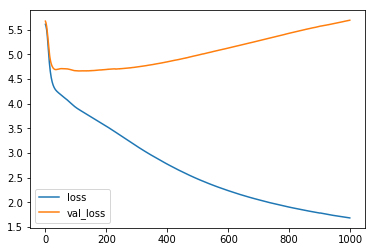

In [37]:
plt.plot(train.history['loss'], label='loss')
plt.plot(train.history['val_loss'], label='val_loss')
plt.legend()

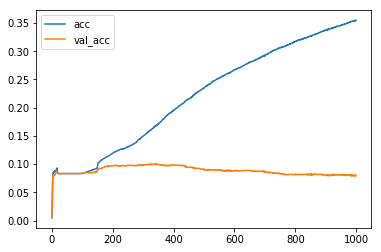

In [38]:
plt.plot(train.history['acc'], label='acc')
plt.plot(train.history['val_acc'], label='val_acc')
plt.legend()

### New model to generate poem

In this session we will build a new model to generate poetry. 

In Keras we must specify the input seqence length beforehand, for training this was the length of the longest sentence in the poem. This was ok for training since the training is done using teacher forcing method but it will not work for the generative session. This is because in generative session, the output from the first LSTM unit is used as the input to the next LSTM unit and so on. 

For Example: 

 - sos = x1, this gives y1
 - y1 = x2, this gives y2
 - y2 = x3, this gives y3 and so on .....
 
We will sample a random word and ask the model to predict the next word. The next word is calculated by taking the argmax of the predicted words so that we will get word with the highest probability. This word is passed on as the next input and so on in a for loop. Note that we will be using the pre-trained state values from the trained model here and this is why we had to manually initialize the hidden and cell states when we built the model. 

In [39]:
# we'll only input one word at a time
    
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
generative_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [40]:
# reverse word2idx dictionary to get back words
# during prediction

idx2word = {value:key for key, value in word2idx.items()}

In [41]:
def generate_poem():
    
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, HIDDEN_DIM))
    c = np.zeros((1, HIDDEN_DIM))
    
    
    eos = word2idx['<eos>']
    
    output_sentence = []
    
    for _ in range(max_sequence_length):
        
        o, h, c = generative_model.predict([np_input, h, c])
        
        probs = o[0,0]
            
        if np.argmax(probs) == 0:
            
            print("wtf")
            
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)    
        
        if idx == eos:
            break
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
        
        np_input[0,0] = idx
        
        
    return ' '.join(output_sentence) 

### Generate a 4 line poem

We will generate 4 lines of poem as an infinite loop, this loop goes on till we quit manually. Generally Robert Frost poems are 4 lines per verse, that's why we are generating 4 lines here so that it can be interpretable. 

In [42]:
while True:
    for _ in range(4):
        print(generate_poem())

    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
        break

and bring the which was no have them tended:
the you, is me. he kept its kitchen to gold,
'well i—'
that means the avalanches,
---generate another? [Y/n]---y
nor granny's, surely. take his house that sailing like such the empty
done?
the january teeth.
it is to other that night
---generate another? [Y/n]---y
could matter to fathom
and tell some color and shouted, 'shut after cider, the shut,
in leaves no joined in me
the chimney glass to south across a low of dishes
---generate another? [Y/n]---y
'take one,' mother that me say all that. he inquired. 'no much
of tying together
(the timber-
but all the young and forty still been trees
---generate another? [Y/n]---y
they'll tell me say two again to familiar traps
faster or mountain like a going to all with over
drawn into the book in trees,
toffile alone fate
---generate another? [Y/n]---y
its voices decently they're witch?
i would on.
he had looked down take had lingered brown,
he'd only idled down.'
---generate another? [Y/n]---n
